In [2]:
import pandas as pd 
df=pd.read_csv(r"C:\Users\shrey\Downloads\heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape


(303, 14)

In [9]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [11]:
df.duplicated().sum()

1

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()

0

In [15]:
df.shape

(302, 14)

In [16]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [37]:
df['target'].value_counts()

target
1    164
0    138
Name: count, dtype: int64

In [22]:
import numpy as np, time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [23]:
x = df.drop(columns=['target'])
y = df['target']

In [44]:
x['age_chol_ratio'] = x['age'] / x['chol']
x['bp_times_age'] = x['trestbps'] * x['age']

In [45]:
candidate_cols = x.columns.tolist()
cat_cols = [c for c in candidate_cols if x[c].nunique() <= 6]
num_cols = [c for c in candidate_cols if c not in cat_cols]
for c in cat_cols:
    print(f" - {c}: {sorted(x[c].unique())} (n={x[c].nunique()})")
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)
print("Train size:", x_train.shape[0], "Test size:", x_test.shape[0])

 - sex: [0, 1] (n=2)
 - cp: [0, 1, 2, 3] (n=4)
 - fbs: [0, 1] (n=2)
 - restecg: [0, 1, 2] (n=3)
 - exang: [0, 1] (n=2)
 - slope: [0, 1, 2] (n=3)
 - ca: [0, 1, 2, 3, 4] (n=5)
 - thal: [0, 1, 2, 3] (n=4)
Train size: 226 Test size: 76


In [46]:
def evaluate_pipeline(name, pipe, x_train, x_test, y_train, y_test,x, y, cv):
    t0 = time.time()
    pipe.fit(x_train, y_train)
    fit_time = time.time() - t0
    y_pred = pipe.predict(x_test)
    # probability / score for ROC AUC
    y_score = None
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        try:
            y_score = pipe.predict_proba(x_test)[:, 1]
        except Exception:
            y_score = None
    if y_score is None and hasattr(pipe.named_steps['clf'], "decision_function"):
        try:
            y_score = pipe.decision_function(x_test)
        except Exception:
            y_score = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    rocauc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    
    # 5-fold CV ROC-AUC with StratifiedKFold passed in
    try:
        cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
        cv_mean = float(np.mean(cv_scores))
    except Exception as e:
        cv_mean = np.nan
        cv_scores = None

    print(f"\n--- {name} evaluation ---")
    print(f"Fit time: {fit_time:.2f}s")
    print("Test accuracy: ", round(acc,4))
    print("Test precision:", round(prec,4))
    print("Test recall:   ", round(rec,4))
    print("Test F1:       ", round(f1,4))
    print("Test ROC-AUC:  ", round(rocauc,4) if not np.isnan(rocauc) else "N/A")
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if cv_scores is not None:
        print("5-fold CV ROC-AUC scores:", [round(s,4) for s in cv_scores])
        print("5-fold CV ROC-AUC mean: ", round(cv_mean,4))
    return pipe, {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':rocauc, 'cv5_mean':cv_mean}

print("\n# STEP 6 - Define models and run them one-by-one")
models_info = {}


# STEP 6 - Define models and run them one-by-one



--- Logistic Regression evaluation ---
Fit time: 0.02s
Test accuracy:  0.8026
Test precision: 0.7826
Test recall:    0.878
Test F1:        0.8276
Test ROC-AUC:   0.8948

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        35
           1       0.78      0.88      0.83        41

    accuracy                           0.80        76
   macro avg       0.81      0.80      0.80        76
weighted avg       0.81      0.80      0.80        76

Confusion matrix:
 [[25 10]
 [ 5 36]]

--- Random Forest evaluation ---
Fit time: 0.43s
Test accuracy:  0.7368
Test precision: 0.7234
Test recall:    0.8293
Test F1:        0.7727
Test ROC-AUC:   0.8693

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.63      0.69        35
           1       0.72      0.83      0.77        41

    accuracy                           0.74        76
   macro avg       0.74      0.7

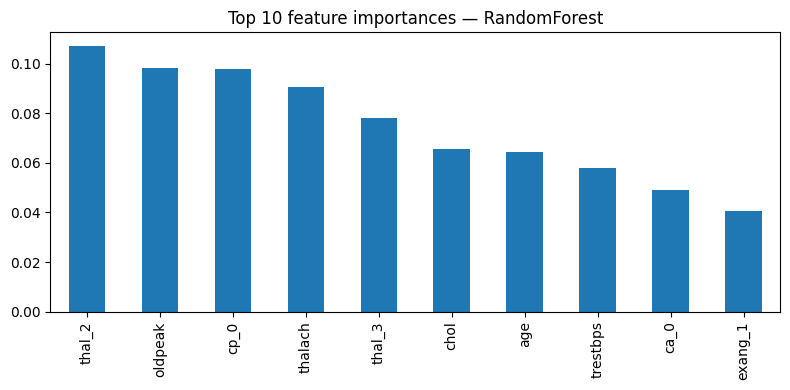


Model: GradientBoosting
Number of features after preprocessing: 30

Top features by importance:
 thal_2      0.311637
cp_0        0.163604
oldpeak     0.106772
chol        0.084459
ca_0        0.061996
thalach     0.044397
age         0.041037
trestbps    0.031953
exang_0     0.021731
slope_1     0.019700


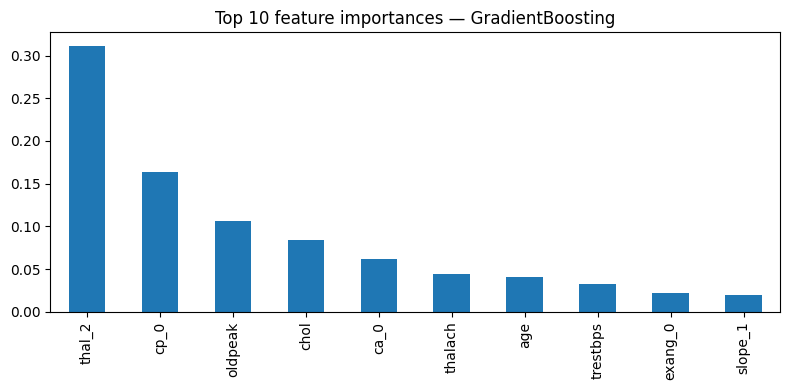


# STEP 8 - Save results summary to CSV
Saved summary to: model_results_summary_step_by_step.csv

Results summary:
                     accuracy  precision  recall      f1  roc_auc  cv5_mean
model                                                                     
LogisticRegression    0.8026     0.7826  0.8780  0.8276   0.8948       NaN
RandomForest          0.7368     0.7234  0.8293  0.7727   0.8693       NaN
GradientBoosting      0.7763     0.7727  0.8293  0.8000   0.8495       NaN

Finished step-by-step run. If you want explanations for any step or want me to tune a model next, tell me which model to tune.


In [32]:
# Logistic Regression pipeline
lr_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_pipe, lr_stats = evaluate_pipeline("Logistic Regression", lr_pipe, x_train, x_test, y_train, y_test, x, y, cv)
models_info['LogisticRegression'] = (lr_pipe, lr_stats)

# Random Forest pipeline
rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
rf_pipe, rf_stats = evaluate_pipeline("Random Forest", rf_pipe, x_train, x_test, y_train, y_test, x, y, cv)
models_info['RandomForest'] = (rf_pipe, rf_stats)

# Try XGBoost, else use sklearn's GradientBoosting
try:
    from xgboost import XGBClassifier
    xgb_pipe = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
    xgb_pipe, xgb_stats = evaluate_pipeline("XGBoost", xgb_pipe, x_train, x_test, y_train, y_test, x, y, cv)
    models_info['XGBoost'] = (xgb_pipe, xgb_stats)
    xgb_available = True
except Exception as e:
    gb_pipe = Pipeline([('pre', preprocessor), ('clf', GradientBoostingClassifier(random_state=42))])
    gb_pipe, gb_stats = evaluate_pipeline("Gradient Boosting (sklearn)", gb_pipe, x_train, x_test, y_train, y_test, x, y, cv)
    models_info['GradientBoosting'] = (gb_pipe, gb_stats)
    xgb_available = False

print("\n# STEP 7 - Feature importances / coefficients")
def get_feature_names_after_preprocessing(fitted_preprocessor):
    # numeric names are num_cols, categorical names come from OneHotEncoder
    num_names = num_cols
    try:
        cat_transformer = fitted_preprocessor.named_transformers_['cat']
        cat_names = list(cat_transformer.get_feature_names_out(cat_cols))
    except Exception:
        # fallback: generate simple names
        cat_names = []
    return num_names + cat_names

# For each model, print top features
for name, (pipe, stats) in models_info.items():
    print(f"\nModel: {name}")
    clf = pipe.named_steps['clf']
    pre = pipe.named_steps['pre']
    try:
        feature_names = get_feature_names_after_preprocessing(pre)
    except Exception:
        feature_names = None
    if feature_names is not None:
        print("Number of features after preprocessing:", len(feature_names))
    else:
        print("Could not extract feature names")

    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        print("\nTop features by importance:\n", fi.head(10).to_string())
        # plot top 10
        plt.figure(figsize=(8,4))
        fi.head(10).plot(kind='bar')
        plt.title(f"Top 10 feature importances — {name}")
        plt.tight_layout()
        plt.show()
    elif hasattr(clf, "coef_"):
        coefs = clf.coef_[0]
        coef_df = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
        print("\nTop features by absolute coefficient value:\n", coef_df.head(10).to_string())
        print("\nTop positive coefficients:\n", coef_df[coef_df>0].head(5).to_string())
        print("\nTop negative coefficients:\n", coef_df[coef_df<0].head(5).to_string())

print("\n# STEP 8 - Save results summary to CSV")
results_summary = []
for name, (pipe, stats) in models_info.items():
    d = {'model': name}
    d.update(stats)
    results_summary.append(d)
results_df = pd.DataFrame(results_summary).set_index('model').round(4)
csv_path = 'model_results_summary_step_by_step.csv'


results_df.to_csv(csv_path)
print("Saved summary to:", csv_path)
print("\nResults summary:\n", results_df.to_string())

# If caas_jupyter_tools is available, show interactive table (optional)
try:
    import caas_jupyter_tools as cjt
    cjt.display_dataframe_to_user("Model evaluation summary (step-by-step)", results_df)
except Exception:
    pass

print("\nFinished step-by-step run. If you want explanations for any step or want me to tune a model next, tell me which model to tune.")


In [47]:
# Logistic Regression pipeline
lr_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, solver='liblinear',class_weight='balanced'))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_pipe, lr_stats = evaluate_pipeline("Logistic Regression", lr_pipe, x_train, x_test, y_train, y_test, x, y, cv)
models_info['LogisticRegression'] = (lr_pipe, lr_stats)



--- Logistic Regression evaluation ---
Fit time: 0.01s
Test accuracy:  0.8158
Test precision: 0.814
Test recall:    0.8537
Test F1:        0.8333
Test ROC-AUC:   0.8969

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.81      0.85      0.83        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76

Confusion matrix:
 [[27  8]
 [ 6 35]]
